In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('data/housing.csv')
df

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273.0,21.0,393.45,6.48,22.0


In [3]:
df.head()
df.tail()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273.0,21.0,393.45,6.48,22.0
505,0.04741,0.0,11.93,0,0.573,6.030,80.8,2.5050,1,273.0,21.0,396.90,7.88,11.9


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    int64  
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB


In [5]:
df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


In [6]:
len(df)
df.shape
df.columns
df.index

506

(506, 14)

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT', 'MEDV'],
      dtype='object')

RangeIndex(start=0, stop=506, step=1)

In [7]:
df['CHAS'].value_counts()
df['RAD'].value_counts()

CHAS
0    471
1     35
Name: count, dtype: int64

RAD
24    132
5     115
4     110
3      38
6      26
8      24
2      24
1      20
7      17
Name: count, dtype: int64

In [8]:
df.iloc[0]
type(df.iloc[0])

CRIM         0.00632
ZN          18.00000
INDUS        2.31000
CHAS         0.00000
NOX          0.53800
RM           6.57500
AGE         65.20000
DIS          4.09000
RAD          1.00000
TAX        296.00000
PTRATIO     15.30000
B          396.90000
LSTAT        4.98000
MEDV        24.00000
Name: 0, dtype: float64

pandas.core.series.Series

In [9]:
df.iloc[:2]
type(df.iloc[:2])

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.9,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.9,9.14,21.6


pandas.core.frame.DataFrame

In [10]:
df.iloc[:2, 0]
type(df.iloc[:2, 0])

0    0.00632
1    0.02731
Name: CRIM, dtype: float64

pandas.core.series.Series

In [11]:
df.loc[[0, 2, 5]]
df.loc[[0, 2, 5], ['TAX', 'RAD']]

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
5,0.02985,0.0,2.18,0,0.458,6.430,58.7,6.0622,3,222.0,18.7,394.12,5.21,28.7


,TAX,RAD
0,296.0,1
2,242.0,2
5,222.0,3


In [12]:
df.loc[[0, 2, 5], ['TAX']]
type(df.loc[[0, 2, 5], ['TAX']])

df.loc[[0, 2, 5], 'TAX']
type(df.loc[[0, 2, 5], 'TAX'])

,TAX
0,296.0
2,242.0
5,222.0


pandas.core.frame.DataFrame

0    296.0
2    242.0
5    222.0
Name: TAX, dtype: float64

pandas.core.series.Series

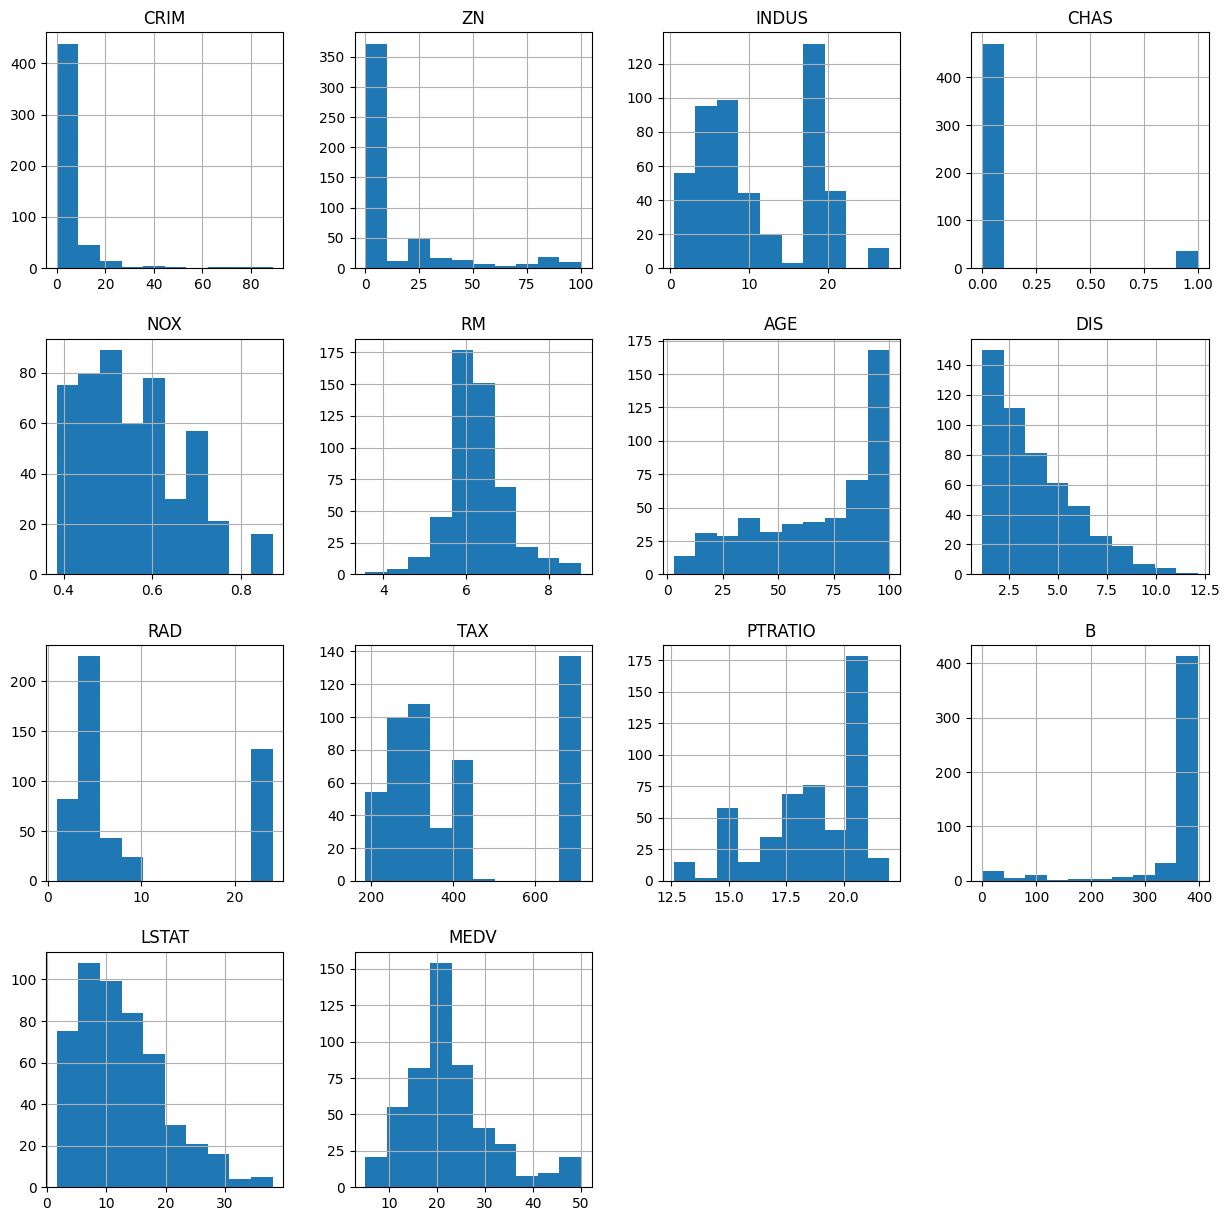

In [13]:
_ = df.hist(bins=10, figsize=(15, 15))

# Train test split
### Manual split logic

Split whole data in 2 parts
1. Training data: used to train models, (80%)
2. Testing data: used to test models, (20%)

Make sure training and testing data, both have good diversity of data

e.g. Suppose 100 students data

Below is a bad splitting (not enough girls in train data)
- Train data: 80 students (75 boys, 1 girls)
- Test data: 20 students (10 boys, 10 girls)

In [14]:
def split_train_test(df, test_ratio=0.2, random_state=42):
  np.random.seed(random_state)
  shuffled = np.random.permutation(len(df))
  test_size = math.ceil(len(df) * test_ratio)

  test_indices = shuffled[:test_size]
  train_indices = shuffled[test_size:]

  test_data = df.iloc[test_indices]
  train_data = df.iloc[train_indices]

  return train_data, test_data


train_data, test_data = split_train_test(df, test_ratio=0.2, random_state=42)

train_data.shape
test_data.shape

(404, 14)

(102, 14)

### Using `split_train_test` from sklearn

In [15]:
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

train_data.shape
test_data.shape

(404, 14)

(102, 14)

### Stratified sampling

In [16]:
train_data['RAD'].value_counts()
test_data['RAD'].value_counts()

RAD
24    101
5      94
4      80
3      32
6      23
8      21
2      21
1      17
7      15
Name: count, dtype: int64

RAD
24    31
4     30
5     21
3      6
6      3
2      3
1      3
8      3
7      2
Name: count, dtype: int64

In [17]:
from sklearn.model_selection import StratifiedShuffleSplit

In [18]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_indices, test_indices in split.split(df, df['RAD']):
  _train_data = df.iloc[train_indices]
  _test_data = df.iloc[test_indices]

_train_data.shape
_test_data.shape

(404, 14)

(102, 14)

In [19]:
_train_data['RAD'].value_counts()
_test_data['RAD'].value_counts()

RAD
24    105
5      92
4      88
3      30
6      21
2      19
8      19
1      16
7      14
Name: count, dtype: int64

RAD
24    27
5     23
4     22
3      8
6      5
2      5
8      5
1      4
7      3
Name: count, dtype: int64

# Analysis starts here

**Context:** Housing values in Boston suburbs (1978). 506 instances, 14 attributes.

### Key Attributes
* **CRIM**: Per capita crime rate.
* **ZN**: Proportion of residential land for large lots (>25k sq.ft).
* **INDUS**: Proportion of non-retail business acres.
* **CHAS**: Charles River dummy (1 if bounds river; 0 otherwise).
* **NOX**: Nitric oxides concentration (pollution).
* **RM**: Avg. number of rooms per dwelling.
* **AGE**: % of units built prior to 1940.
* **DIS**: Distance to employment centers.
* **RAD**: Accessibility to radial highways.
* **TAX**: Property-tax rate.
* **PTRATIO**: Pupil-teacher ratio.
* **B**: Proportion of population of Black descent (statistically transformed).
* **LSTAT**: % lower status of the population.
* **MEDV (Target)**: Median value of owner-occupied homes ($1000s).

**Source:** Harrison & Rubinfeld (1978). Missing Values: None.

In [21]:
students = pd.DataFrame({
    "name": ['rahul', 'harikesh', 'vishnu', 'paru', 'vidu', 'maa'],
    "age": [22, 23, 10, 15, 21, 45],
    "marks": [60, 70, 30, 43, 50, 90],
    "is_boy": [1, 1, 1, 0, 0, 0],
    "salary": [900, 800, 400, 4500, 6000, 8500],
})

corr = students.iloc[:, 1:].corr().abs()
mask1 = np.triu(np.ones(corr.shape), k=1).astype(bool)
mask2 = corr >= 0.5
corr.where(mask1 & mask2).fillna('-')

,age,marks,is_boy,salary
age,-,0.944124,-,0.696811
marks,-,-,-,-
is_boy,-,-,-,0.922726
salary,-,-,-,-


In [22]:
corr = df.corr().abs()

# Mask the upper triangle (to avoid duplicate pairs like (A, B) and (B, A))
# and remove self-correlation (where corr == 1)
mask1 = np.triu(np.ones(corr.shape), k=1).astype(bool)
mask2 = corr >= 0.6

corr.where(mask1 & mask2).fillna('-')

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
CRIM,-,-,-,-,-,-,-,-,0.625505,-,-,-,-,-
ZN,-,-,-,-,-,-,-,0.664408,-,-,-,-,-,-
INDUS,-,-,-,-,0.763651,-,0.644779,0.708027,-,0.72076,-,-,0.6038,-
CHAS,-,-,-,-,-,-,-,-,-,-,-,-,-,-
NOX,-,-,-,-,-,-,0.73147,0.76923,0.611441,0.668023,-,-,-,-
RM,-,-,-,-,-,-,-,-,-,-,-,-,0.613808,0.69536
AGE,-,-,-,-,-,-,-,0.747881,-,-,-,-,0.602339,-
DIS,-,-,-,-,-,-,-,-,-,-,-,-,-,-
RAD,-,-,-,-,-,-,-,-,-,0.910228,-,-,-,-
TAX,-,-,-,-,-,-,-,-,-,-,-,-,-,-


In [35]:
relevant_pairs = list(corr.where(mask1 & mask2).stack().sort_values(ascending=False).index)
relevant_pairs

[('RAD', 'TAX'),
 ('NOX', 'DIS'),
 ('INDUS', 'NOX'),
 ('AGE', 'DIS'),
 ('LSTAT', 'MEDV'),
 ('NOX', 'AGE'),
 ('INDUS', 'TAX'),
 ('INDUS', 'DIS'),
 ('RM', 'MEDV'),
 ('NOX', 'TAX'),
 ('ZN', 'DIS'),
 ('INDUS', 'AGE'),
 ('CRIM', 'RAD'),
 ('RM', 'LSTAT'),
 ('NOX', 'RAD'),
 ('INDUS', 'LSTAT'),
 ('AGE', 'LSTAT')]

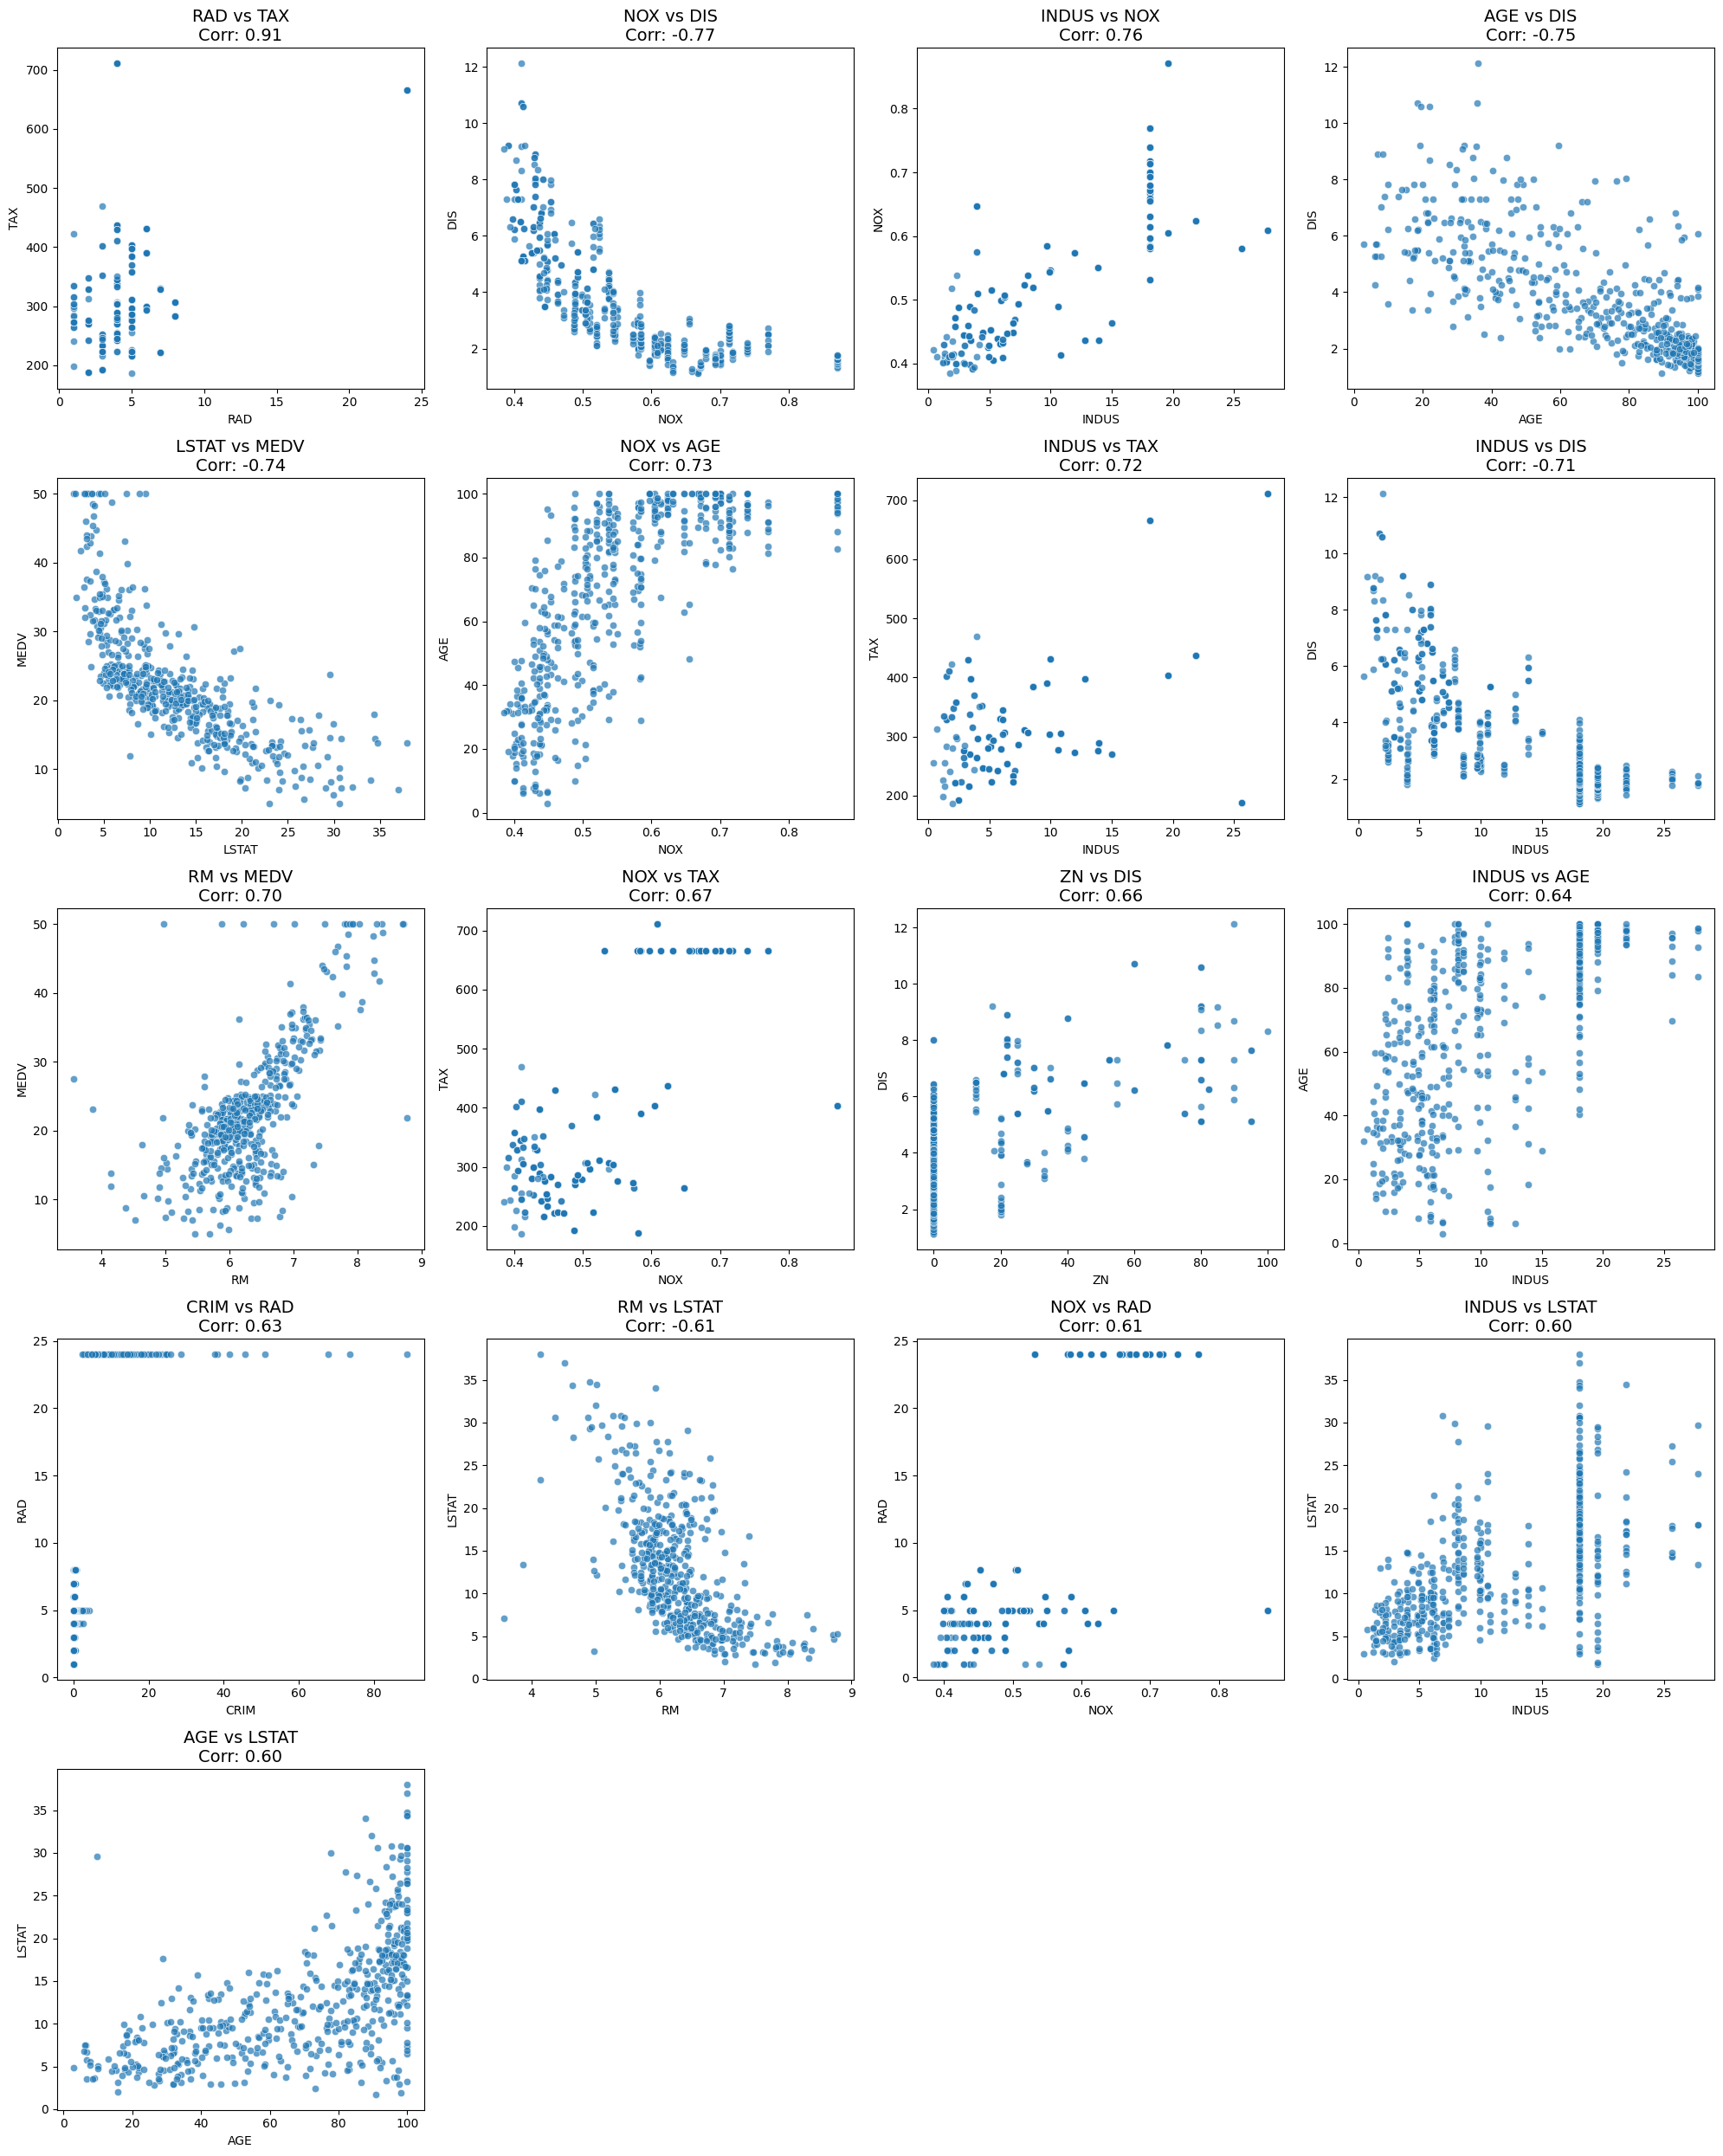

In [51]:
# 1. Calculate grid dimensions
n_plots = len(relevant_pairs)
n_cols = 4
n_rows = math.ceil(n_plots / n_cols)

# 2. Initialize the figure
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
axes = axes.flatten()  # Flatten to iterate easily

# 3. Loop through pairs and create plots
for i, (col_x, col_y) in enumerate(relevant_pairs):
  _ = sns.scatterplot(data=df, x=col_x, y=col_y, ax=axes[i], alpha=0.7)
  correlation = df[col_x].corr(df[col_y])
  _ = axes[i].set_title(f"{col_x} vs {col_y}\nCorr: {correlation:.2f}", fontsize=14)

# 4. Remove empty subplots (if any)
for j in range(i + 1, len(axes)):
  _ = fig.delaxes(axes[j])

plt.tight_layout()

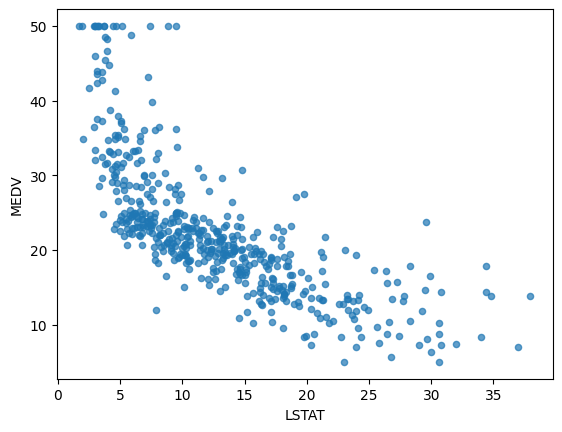

In [54]:
_ = df.plot(kind='scatter', x='LSTAT', y='MEDV', alpha=0.7)